In [13]:
import os
import torch
import pandas as pd
import networkx as nx

from conditional_rate_matching.configs.experiments_configs.crm.crm_experiments_graph import experiment_comunity_small
from conditional_rate_matching.models.generative_models.crm import CRM
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

config = experiment_comunity_small(network="gnn")
config.data0.batch_size = 9
config.data1.batch_size = 9
crm = CRM(config=config)

In [16]:
databatch1 = next(crm.dataloader_1.train().__iter__())
all_adj = databatch1[0]
batch_size = all_adj.shape[0]
number_of_nodes = all_adj.shape[1]

In [21]:
batch_size

9

In [48]:

number_of_edges = 0.
dataset = []
for i in range(batch_size):
    adj = all_adj[i] 
    number_of_edges += adj.sum()
    edge_index = dense_to_sparse(adj)[0]
    number_of_edges += edge_index.shape[-1]
    attributes = torch.eye(number_of_nodes)
    print(attributes.shape)
    dataset.append(Data(x=attributes,edge_index=edge_index))

torch.Size([20, 20])
torch.Size([20, 20])
torch.Size([20, 20])
torch.Size([20, 20])
torch.Size([20, 20])
torch.Size([20, 20])
torch.Size([20, 20])
torch.Size([20, 20])
torch.Size([20, 20])


In [53]:
loader = DataLoader(dataset, batch_size=1)
batch_g = next(loader.__iter__())

In [54]:
batch_g

DataBatch(x=[20, 20], edge_index=[2, 42], batch=[20], ptr=[2])

In [13]:
attributes[None,:,:].repeat((batch_size,1,1)).shape

torch.Size([9, 20, 20])

In [8]:
adj.shape

torch.Size([9, 20, 20])

In [4]:
edge_index = dense_to_sparse(adj)[0]
edge_attributes = dense_to_sparse(adj)[1]

In [5]:
edge_index.shape

torch.Size([2, 636])

In [7]:
edge_attributes.shape

torch.Size([636])

In [ ]:
conv1 = GCNConv(dataset.num_features, 4)

In [30]:
#crm.dataloader_1.sample_to_graph(databatch1[0])[0]

# Dario's Unet

In [ ]:
from torch import nn

class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2
        
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)
    
class TemporalUNet(nn.Module):

    def __init__(self,
                 config,
                 device):

        super().__init__()
        self.dimensions = config.data0.dimensions
        self.vocab_size = config.data0.vocab_size
        self.time_embed_dim = config.temporal_network.time_embed_dim
        self.hidden_dim = config.temporal_network.hidden_dim
        self.Encoder()
        self.TimeEmbedding()
        self.Decoder()
        self.to(device)
        self.expected_output_shape = [28, 28, self.vocab_size]

    def Encoder(self):
        self.init_conv = ResidualConvBlock(1, self.hidden_dim , is_res=True)
        self.down1 = UnetDown(self.hidden_dim, self.hidden_dim)
        self.down2 = UnetDown(self.hidden_dim, 2 * self.hidden_dim)
        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

    def TimeEmbedding(self):
        self.timeembed1 = EmbedFC(1, 2*self.hidden_dim)
        self.timeembed2 = EmbedFC(1, 1*self.hidden_dim)

    def Decoder(self):
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * self.hidden_dim, 2 * self.hidden_dim, 7, 7), 
            nn.GroupNorm(8, 2 * self.hidden_dim),
            nn.GELU())

        self.up1 = UnetUp(4 * self.hidden_dim, self.hidden_dim)
        self.up2 = UnetUp(2 * self.hidden_dim, self.hidden_dim)
        self.out = nn.Sequential(
            nn.Conv2d(2 * self.hidden_dim, self.hidden_dim, 3, 1, 1),
            nn.GroupNorm(8, self.hidden_dim),
            nn.GELU(),
            nn.Conv2d(self.hidden_dim, self.vocab_size, 3, 1, 1),
        )

    def forward(self, x, times):
        x = self.init_conv(x)
        
        # encode:
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # embed:
        temb1 = self.timeembed1(times).view(-1, self.hidden_dim * 2, 1, 1)
        temb2 = self.timeembed2(times).view(-1, self.hidden_dim, 1, 1)
        
        # decode:
        up1 = self.up0(hiddenvec)
        up2 = self.up1(up1 + temb1, down2) 
        up3 = self.up2(up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))

        return out.permute(0, 2, 3, 1) 


# Torch Geometric Tutorial

## Plotting Functions

In [7]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.1.2+cu118


In [5]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [8]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Graphs


In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

In [14]:
model = GCN()

_, h = model(data.x, data.edge_index)

Embedding shape: [34, 2]


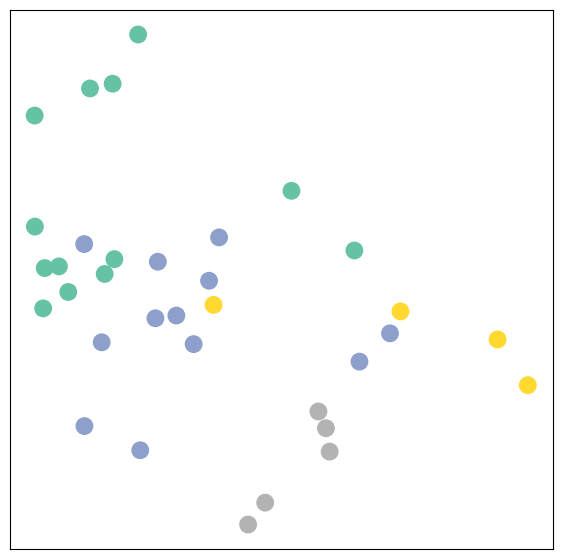

In [11]:
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)